In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gc 

%matplotlib inline

In [2]:
def pretty_network_draw(G):
    """Draw weighted graph using standard networkx function."""
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

    pos=nx.spring_layout(G) # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=200)

    # edges
    nx.draw_networkx_edges(G,pos,edgelist=elarge,
                        width=6)
    nx.draw_networkx_edges(G,pos,edgelist=esmall,
                        width=6,alpha=0.5,edge_color='b',style='dashed')

    # labels
    nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')

    plt.axis('off')
    plt.savefig("weighted_graph_.png") # save as png
    plt.show() # display

In [3]:
class politicalGraph(object):
    
    def __init__(self, num_votes = 500, num_nodes = 435,
                 conform_pr = 0.5, selection_mech = "stoch_accept"):
        
        self.num_votes = num_votes
        self.num_nodes = num_nodes
        self.selection_mech = selection_mech
        G = nx.Graph()
        self.conform_pr = conform_pr
        
        for i in range(self.num_nodes):
            conform = np.random.binomial(1, self.conform_pr)
            ntype = "conformist" if conform else "idealist"
            G.add_node(i, politician = {"ntype" : ntype, "signal" : "A", "vote" : "A"})
            
        for i in G.nodes():
            for j in G.nodes():
                if i != j:
                    G.add_edge(i, j, weight = np.random.uniform(low = 0.0, high = 1.0))
                    
        self.graph = G
        
    def run(self, num_steps, verbose = False):
        """Runs defined steps of evolution on the initialized graph."""
        proportion = []
        for i in range(num_steps):
            self._step()
            self._evolve()
            if verbose:
                proportion.append(self.idealist_proportion())
                # print (self.idealist_proportion())
        return proportion
    
    def _step(self):
        """One step of voting dymanics excluding the evolution process."""
        for i in range(self.num_votes):
            
            self._signal()
            self._vote()
            self._vote_effect()
    
    def draw(self):
        """Draws current state of the graph."""
        pretty_network_draw(self.graph)
    
    def _signal(self, prob = 0.5):
        """Round of signaling for nodes, initially happens randomly."""
        for i in self.graph.nodes():
            self.graph.node[i]['politician']['signal'] = "A" if np.random.binomial(1, prob) else "B"
    
    def _calculate_vote(self, node):
        
        A_score = 0
        B_score = 0
        
        for i in self.graph.neighbors(node):
            if self.graph.node[i]['politician']["signal"] == 'A':
                A_score += self.graph[node][i]["weight"]

            else:
                B_score += self.graph[node][i]["weight"]

        return "A" if A_score > B_score else "B"
    
    def idealist_proportion(self):
        counter = 0
        for node in self.graph.nodes():
            if self.graph.node[node]["politician"]["ntype"] == "idealist":
                counter += 1
                
        return counter / float(self.num_nodes)
    
    def _vote(self):
        """Voting in which nodes based on their types do the final decision"""
        for i in self.graph.nodes():
            if self.graph.node[i]['politician']["ntype"] == "idealist":
                self.graph.node[i]['politician']["vote"] = self.graph.node[i]['politician']["signal"]
               
            else:
                self.graph.node[i]['politician']["vote"] = self._calculate_vote(i)
    
    def _vote_effect(self):
        """Calculate the change in relations after the current voting."""
        for edge in self.graph.edges():
            if self.graph.node[edge[0]]['politician']["vote"] == self.graph.node[edge[1]]['politician']["vote"]:
                self.graph[edge[0]][edge[1]]["weight"] = min(1.1 * self.graph[edge[0]][edge[1]]["weight"], 1.0)
            else:
                self.graph[edge[0]][edge[1]]["weight"] /= 1.1
    
    def _fitness(self, node):
        return sum([self.graph.adj[node][x]['weight'] if x in self.graph.adj[node].keys()
                    else 0 for x in self.graph.nodes()])
    
    def _evolve(self):
        self._mutate()
        self._select()
    
    def _select(self):
        self.conform_pr = sum([1 if self.graph.node[x]['politician']["ntype"] == "conformist" else 0
                          for x in self.graph.nodes()]) / self.num_nodes
        
        if self.selection_mech == "stoch_accept":
            
            top = max([self._fitness(node) for node in self.graph.nodes()])
            
            for node in self.graph.nodes():
                if not np.random.binomial(1, self._fitness(node) / top):
                    self.graph.remove_node(node)
    
    def avg_weight(self):
        return sum([d['weight'] for (u,v,d) in self.graph.edges(data=True)]) / float(len(self.graph.edges()))
    
    def _mutate(self):
        # TODO nodes added later have advantage fix
        
        for i in range(self.num_nodes):
            if not self.graph.has_node(i):
                avg_weight = self.avg_weight()
                conform = np.random.binomial(1, self.conform_pr)
                ntype = "conformist" if conform else "idealist"
                self.graph.add_node(i, politician = {"ntype" : ntype, "signal" : "A", "vote" : "A"})
                
                for j in self.graph.nodes():
                    if i != j:
                        self.graph.add_edge(i, j, weight = avg_weight)
  

In [35]:
congress = politicalGraph(num_nodes = 100, conform_pr=0.7)

In [20]:
proportions = congress.run(num_steps = 20, verbose=True)

0.2
0.1
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.1
0.1
0.1
0.2
0.2
0.1
0.1
0.1
0.1


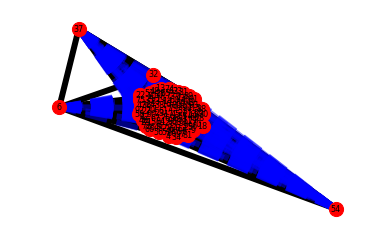

In [36]:
congress.draw()

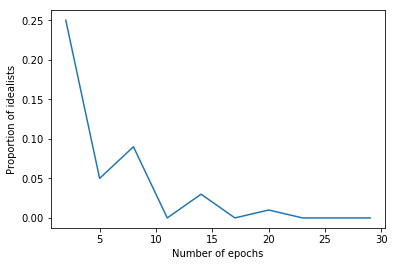

In [30]:
proportions = []

for i in range(2, 32, 3):
    senate = politicalGraph(num_votes = 160, num_nodes=100)
    proportions.append(senate.run(i, verbose = True)[i - 1])
    del senate
    gc.collect()

plt.plot(range(2, 32, 3), proportions)
plt.xlabel("Number of epochs")
plt.ylabel("Proportion of idealists")
plt.savefig("Idealists_survivability_on_num_epochs.png")

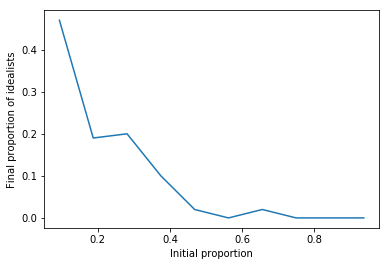

In [32]:
proportions = []

for i in range(2, 32, 3):
    senate = politicalGraph(num_votes = 160, num_nodes=100, conform_pr= 1 - i / float(32))
    proportions.append(senate.run(10, verbose = True)[9])
    del senate
    gc.collect()

plt.plot([1 - (i / float(32)) for i in range(2, 32, 3)], proportions)
plt.xlabel("Initial proportion")
plt.ylabel("Final proportion of idealists")
plt.savefig("Idealists_survivability_on_initial_prop.png")

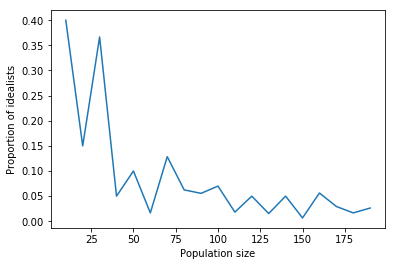

In [34]:
proportions = []

for i in range(10, 200, 10):
    senate = politicalGraph(num_votes = 160, num_nodes=i)
    proportions.append(senate.run(10, verbose = True)[9])
    del senate
    gc.collect()

plt.plot(range(10, 200, 10), proportions)
plt.xlabel("Population size")
plt.ylabel("Proportion of idealists")
plt.savefig("Idealists_survivability_on_pop_size.png")

In [18]:
class realPolGraph(politicalGraph):
    
    def __init__(self, votes_map, names, num_votes = 500, num_nodes = 435,
                 conform_pr = 0.5, selection_mech = "stoch_accept"):
        
        self.num_votes = num_votes
        self.num_nodes = num_nodes
        self.selection_mech = selection_mech
        G = nx.Graph()
        self.conform_pr = conform_pr
        self.votes_map = votes_map
        self.names = names
        
        for i in range(self.num_nodes):
            conform = np.random.binomial(1, self.conform_pr)
            ntype = "real"
            G.add_node(i, politician = {"ntype" : ntype, "signal" : "A", "vote" : "A"})
            
        for i in G.nodes():
            for j in G.nodes():
                if i != j:
                    G.add_edge(i, j, weight = np.random.uniform(low = 0.0, high = 1.0))
                    
        self.graph = G
        
    def run(self, num_steps):
        """Runs defined steps of evolution on the initialized graph."""
        for i in range(num_steps):
            self._step()
            self._select()
            
            # self._mutate()
        return self.graph.nodes()
    
    def _step(self):
        """One step of voting dymanics excluding the evolution process."""
        for j in range(self.num_votes):
            
            self._signal()
            self._vote(j)
            self._vote_effect()
    
   
    def _vote(self, j):
        """Voting in which nodes based on their types do the final decision"""
        for i in self.graph.nodes():
            self.graph.node[i]['politician']['vote'] = self.votes_map[self.names[i]][j]
            
            
    def _vote_effect(self):
        """Calculate the change in relations after the current voting."""
        for edge in self.graph.edges():
            if self.graph.node[edge[0]]['politician']["vote"] == self.graph.node[edge[1]]['politician']["vote"]:
                self.graph[edge[0]][edge[1]]["weight"] = min(1.05 * self.graph[edge[0]][edge[1]]["weight"], 1.0)
            else:
                self.graph[edge[0]][edge[1]]["weight"] /= 1.05
                
    def _select(self):
        self.conform_pr = sum([1 if self.graph.node[x]['politician']["ntype"] == "conformist" else 0
                          for x in self.graph.nodes()]) / self.num_nodes
        
        if self.selection_mech == "stoch_accept":
            
            top = max([self._fitness(node) for node in self.graph.nodes()])
            
            for node in self.graph.nodes():
                if not np.random.binomial(1, self._fitness(node) / top):
                    self.graph.remove_node(node)
        
        elif self.selection_mech == 'ranking':
            
    

In [5]:
import pickle

with open("votes_map.pickle", 'rb') as handle:
    votes_map = pickle.load(handle)

In [32]:


senate_2010 = realPolGraph(votes_map, list(votes_map.keys()), num_votes = 442, num_nodes = 100)

In [33]:
survivors = senate_2010.run(1)

In [34]:
survivors

[1,
 3,
 4,
 5,
 7,
 8,
 9,
 12,
 15,
 16,
 18,
 21,
 22,
 23,
 26,
 28,
 30,
 33,
 34,
 35,
 37,
 43,
 44,
 45,
 46,
 48,
 49,
 51,
 52,
 55,
 56,
 58,
 61,
 62,
 63,
 68,
 69,
 70,
 72,
 73,
 77,
 78,
 79,
 80,
 82,
 83,
 85,
 89,
 93,
 95,
 97]